In [ ]:
import pandas as pd
import numpy as np
import praw
from datetime import datetime, UTC

import warnings
warnings.filterwarnings('ignore')

# Set up API credentials
reddit = praw.Reddit(
    ## Replace with your own credentials
)

In [2]:
# Test access
subreddit = reddit.subreddit("lakers")
print(f"Subreddit Name: {subreddit.display_name}")
print(f"Title: {subreddit.title}")
print(f"Description: {subreddit.public_description}")

Subreddit Name: lakers
Title: Los Angeles Lakers
Description: The home of your 17x NBA World Champions, the Los Angeles Lakers.


In [3]:
# List to store post details
posts_data = []
limit = 1000 # define the number of records to retrieve

In [4]:
# Fetch posts
for post in subreddit.hot(limit=limit):
    post_date = datetime.fromtimestamp(post.created_utc, UTC).strftime('%Y-%m-%d %H:%M:%S')

    posts_data.append({
        "Title": post.title,
        "Upvotes": post.score,
        "Comments": post.num_comments,
        "Post Date": post_date, # UTC
        "Author": str(post.author),  # Convert to string to avoid issues with deleted users
        "Subreddit": post.subreddit.display_name,
        "Self-text": post.selftext[:] + "..." if post.selftext else "",
        "Flair": post.link_flair_text,
        "Total Awards": post.total_awards_received,
        "NSFW": post.over_18,
        "Stickied": post.stickied,
        "Post URL": post.url
    })

In [5]:
# Convert to DataFrame
df = pd.DataFrame(posts_data)
df.shape

(857, 12)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857 entries, 0 to 856
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Title         857 non-null    object
 1   Upvotes       857 non-null    int64 
 2   Comments      857 non-null    int64 
 3   Post Date     857 non-null    object
 4   Author        857 non-null    object
 5   Subreddit     857 non-null    object
 6   Self-text     857 non-null    object
 7   Flair         331 non-null    object
 8   Total Awards  857 non-null    int64 
 9   NSFW          857 non-null    bool  
 10  Stickied      857 non-null    bool  
 11  Post URL      857 non-null    object
dtypes: bool(2), int64(3), object(7)
memory usage: 68.8+ KB


In [7]:
df.head()

,Title,Upvotes,Comments,Post Date,Author,Subreddit,Self-text,Flair,Total Awards,NSFW,Stickied,Post URL
0,Lakers Ticket Sales - Postseason,14,56,2025-04-04 17:37:38,utopic2,lakers,Previous thread: \n[https://www.reddit.com/r/...,None,0,False,True,https://www.reddit.com/r/lakers/comments/1jrhr...
1,Daily Lakers Discussion Thread,3,41,2025-04-12 14:00:33,AutoModerator,lakers,The Lakers season is here! Talk about whatever...,None,0,False,True,https://www.reddit.com/r/lakers/comments/1jxhy...
2,Lebron james Austin Reaves Lakers tea...,3380,96,2025-04-12 04:42:55,GustoKoNaMagkaGF,lakers,,Video,0,False,False,https://v.redd.it/0w3js7ju2cue1
3,Thank You Coaching Staff!,2044,52,2025-04-12 05:28:53,xvalusx,lakers,Thank you JJ Redick. Thank you you Nate McMil...,None,0,False,False,https://i.redd.it/wemwxjwfacue1.png
4,Lebron James: Man I was going to say something...,1511,81,2025-04-12 05:48:08,Turbostrider27,lakers,,None,0,False,False,https://i.redd.it/5p3uc8jhecue1.jpeg


# Dictionary

| Column Name  | Data Type     | Description                                              | Example                                               |
|--------------|--------------|----------------------------------------------------------|-------------------------------------------------------|
| Title        | String       | The title of the Reddit post.                            | "Breaking News: AI Reaches New Milestone"            |
| Upvotes      | Integer      | The total number of upvotes (post score).                | 5423                                                 |
| Comments     | Integer      | The number of comments on the post.                      | 128                                                  |
| Post Date    | Datetime     | The date and time when the post was created (UTC).        | "2024-04-03 12:30:00"                                |
| Author       | String       | The username of the post author (or "None" if deleted).  | "u/RedditUser123"                                    |
| Subreddit    | String       | The subreddit where the post was published.              | "worldnews"                                          |
| Self-text    | String       | The full text content of the post (if any). Empty if it's a link post. | "This is a detailed post about..."       |
| Flair        | String / None | The label or category assigned to the post in the subreddit. If none, it’s None. | "Discussion", "Meme", None           |
| Total Awards | Integer      | The total number of Reddit awards the post has received. | 5                                                    |
| NSFW         | Boolean      | True if the post is marked as NSFW (Not Safe for Work), otherwise False. | True / False                                      |
| Stickied     | Boolean      | True if the post is pinned (stickied) by moderators, otherwise False. | True / False                                      |
| Post URL     | String       | The direct URL to the post.                              | "https://www.reddit.com/r/worldnews/comments/xyz123/" |

In [8]:
df.isnull().sum()

Title             0
Upvotes           0
Comments          0
Post Date         0
Author            0
Subreddit         0
Self-text         0
Flair           526
Total Awards      0
NSFW              0
Stickied          0
Post URL          0
dtype: int64

##### Feature engineering

In [9]:
luka_keywords = ['77', 'luka', 'doncic', 'magic', 'lukamagic'] # Define the list of keywords for luka doncic based on the nickname, number and name
luka_pattern = '|'.join(luka_keywords) # Create a regex pattern that matches any of the keywords, ignoring case
df['luka_in_title'] = ( # Check if the keywords are present in either the the title or the text of the post
    df['Title'].str.contains(luka_pattern, case=False, na=False) |
    df['Self-text'].str.contains(luka_pattern, case=False, na=False)
)
# Same process for Lebron
lebron_keywords = ['23', 'lebron', 'james', 'king']
lebron_pattern = '|'.join(lebron_keywords) 
df['lebron_in_title'] = (
    df['Title'].str.contains(lebron_pattern, case=False, na=False) |
    df['Self-text'].str.contains(lebron_pattern, case=False, na=False)
)

In [10]:
lebron_or_luka = []

for row in range(len(df['lebron_in_title'])):
    if df['lebron_in_title'][row] and df['luka_in_title'][row]:
        lebron_or_luka.append('both')
    elif df['lebron_in_title'][row] and not df['luka_in_title'][row]:
        lebron_or_luka.append('lebron')
    elif not df['lebron_in_title'][row] and df['luka_in_title'][row]:
        lebron_or_luka.append('luka')
    else:
        lebron_or_luka.append('neither')

df['lebron_or_luka'] = lebron_or_luka
df['lebron_or_luka'].value_counts()

lebron_or_luka
neither    480
luka       164
lebron     114
both        99
Name: count, dtype: int64

# EDA

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
df.describe()

,Upvotes,Comments,Total Awards
count,857.00000,857.000000,857.0
mean,312.61727,72.794632,0.0
std,587.51345,433.933239,0.0
min,0.00000,0.000000,0.0
25%,29.00000,8.000000,0.0
50%,84.00000,19.000000,0.0
75%,299.00000,43.000000,0.0
max,4888.00000,7302.000000,0.0


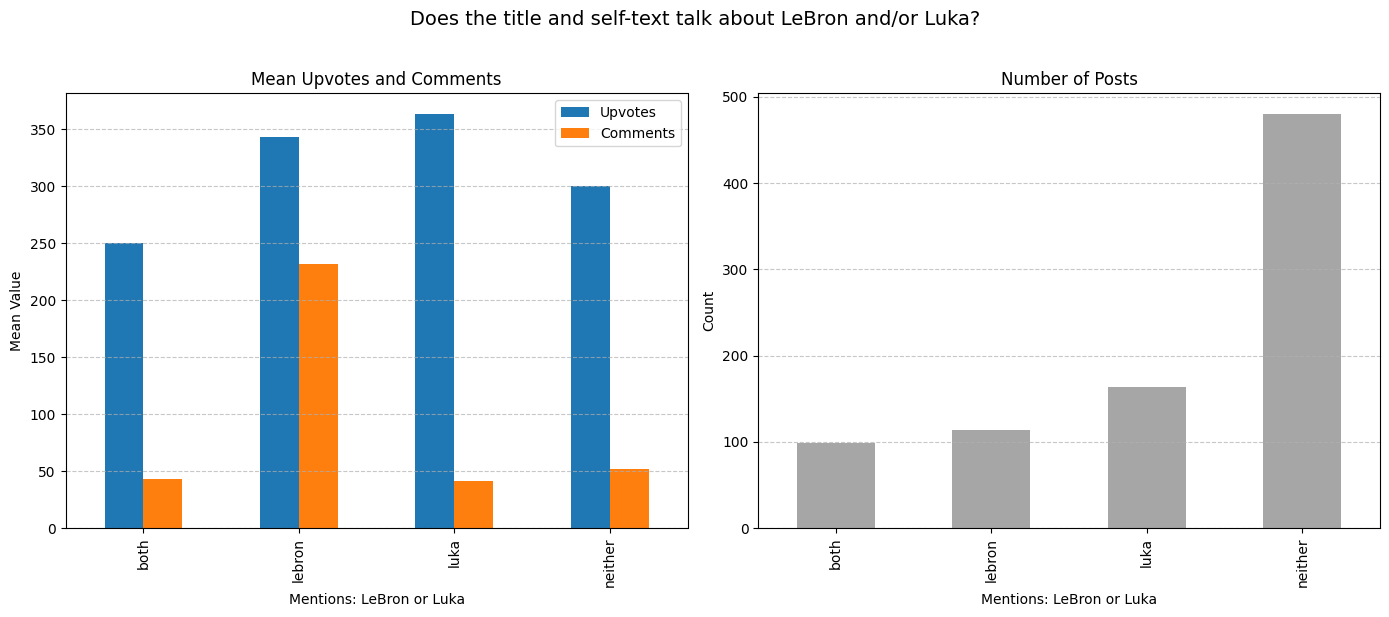

In [13]:
mean_upvotes_comments = df.groupby('lebron_or_luka')[['Upvotes', 'Comments']].mean() # Calculate mean upvotes and comments
counts = df['lebron_or_luka'].value_counts().reindex(mean_upvotes_comments.index) # Calculate value counts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6)) # Create subplots side-by-side

mean_upvotes_comments.plot(kind='bar', ax=ax1) # First plot
ax1.set_title('Mean Upvotes and Comments')
ax1.set_xlabel('Mentions: LeBron or Luka')
ax1.set_ylabel('Mean Value')
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

counts.plot(kind='bar', ax=ax2, color='gray', alpha=0.7) # Second plot
ax2.set_title('Number of Posts')
ax2.set_xlabel('Mentions: LeBron or Luka')
ax2.set_ylabel('Count')
ax2.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.suptitle('Does the title and self-text talk about LeBron and/or Luka?', fontsize=14, y=1.02) # Layout
plt.tight_layout()
plt.show()


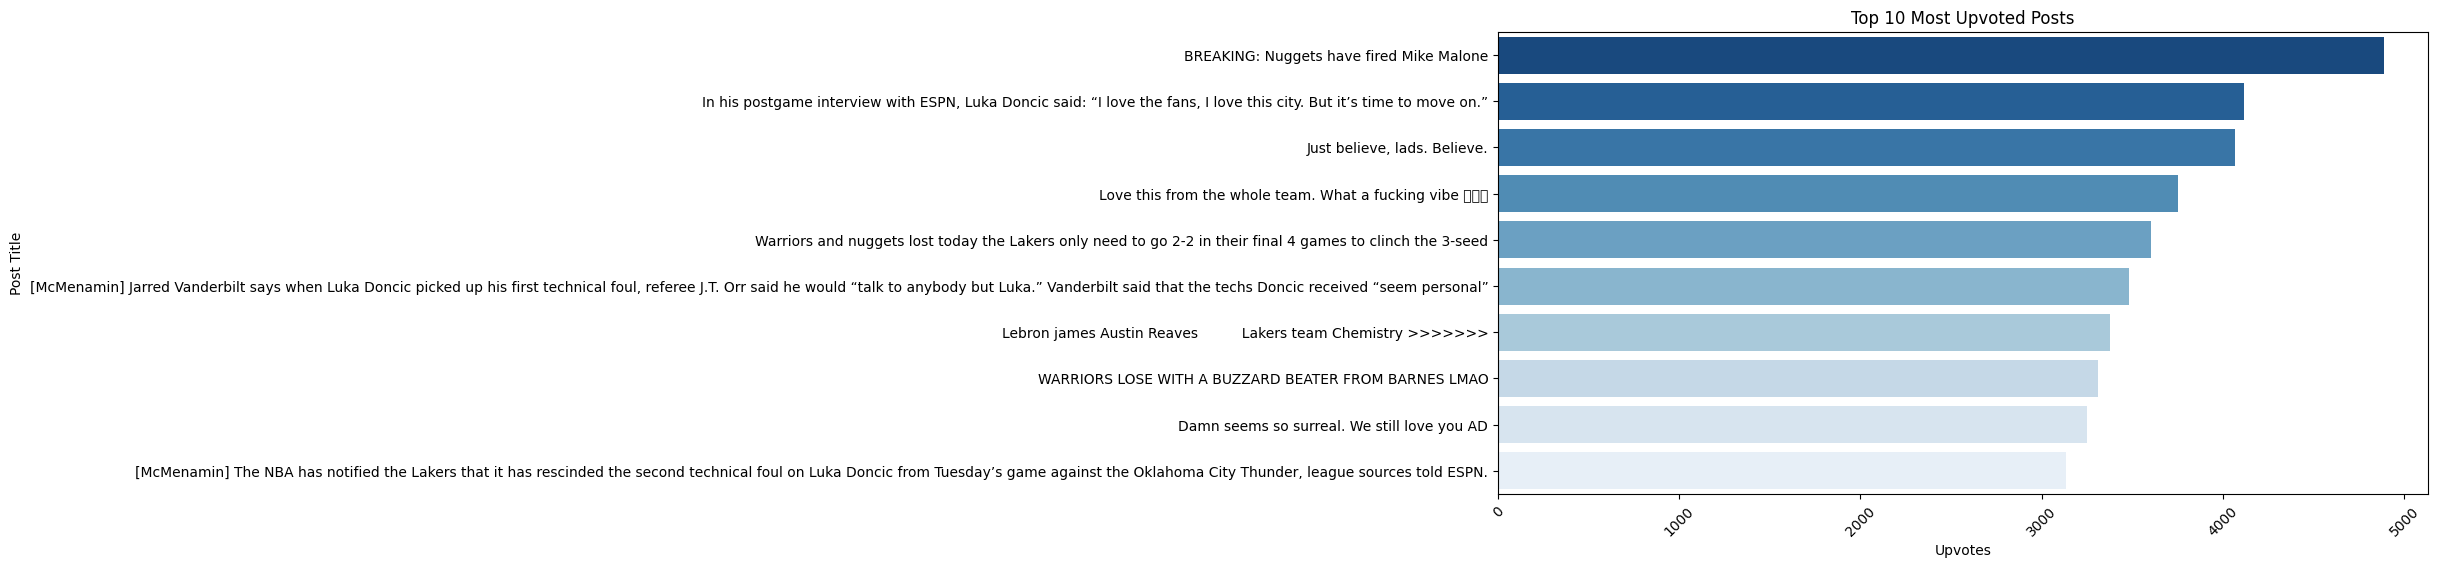

In [14]:
# Top 10 Posts by Upvotes
plt.figure(figsize=(12, 6))
top_upvoted = df.nlargest(10, "Upvotes")
sns.barplot(y=top_upvoted["Title"], x=top_upvoted["Upvotes"], palette="Blues_r")
plt.xlabel("Upvotes")
plt.ylabel("Post Title")
plt.title("Top 10 Most Upvoted Posts")
plt.xticks(rotation=45)
plt.show()

In [15]:
df.nlargest(10, "Upvotes")

,Title,Upvotes,Comments,Post Date,Author,Subreddit,Self-text,Flair,Total Awards,NSFW,Stickied,Post URL,luka_in_title,lebron_in_title,lebron_or_luka
372,BREAKING: Nuggets have fired Mike Malone,4888,1073,2025-04-08 17:27:34,Good-Fold-1815,lakers,,None,0,False,False,https://i.redd.it/yec7xcimbnte1.jpeg,False,True,lebron
174,"In his postgame interview with ESPN, Luka Donc...",4117,197,2025-04-10 02:12:43,incredibleamadeuscho,lakers,,None,0,False,False,https://i.redd.it/lpt99xc82xte1.jpeg,True,False,luka
375,"Just believe, lads. Believe.",4066,490,2025-04-08 17:43:41,edillcolon,lakers,,None,0,False,False,https://i.redd.it/mzgjkf9iente1.jpeg,False,False,neither
176,Love this from the whole team. What a fucking ...,3753,93,2025-04-10 02:34:28,legitimategambler420,lakers,,Upvote/Appreciation Party,0,False,False,https://v.redd.it/8m5qudv36xte1,False,True,lebron
561,Warriors and nuggets lost today the Lakers onl...,3604,208,2025-04-07 02:56:24,angryshoper,lakers,,None,0,False,False,https://i.redd.it/as9ev4mavbte1.jpeg,False,False,neither
323,[McMenamin] Jarred Vanderbilt says when Luka D...,3482,225,2025-04-09 03:20:13,daftmunt,lakers,,None,0,False,False,https://i.redd.it/twn9iv5d9qte1.jpeg,True,False,luka
2,Lebron james Austin Reaves Lakers tea...,3380,96,2025-04-12 04:42:55,GustoKoNaMagkaGF,lakers,,Video,0,False,False,https://v.redd.it/0w3js7ju2cue1,False,True,lebron
170,WARRIORS LOSE WITH A BUZZARD BEATER FROM BARNE...,3310,223,2025-04-10 04:30:27,denobino,lakers,,None,0,False,False,https://i.redd.it/io0ilxmsqxte1.jpeg,False,False,neither
180,Damn seems so surreal. We still love you AD,3252,101,2025-04-10 02:06:20,Firefighter0826,lakers,I wish nothing but the best for AD man this st...,Game Thread,0,False,False,https://i.redd.it/61z2s0e31xte1.jpeg,False,False,neither
202,[McMenamin] The NBA has notified the Lakers th...,3134,388,2025-04-09 21:05:09,daftmunt,lakers,,None,0,False,False,https://i.redd.it/mz84dhwcjvte1.jpeg,True,False,luka


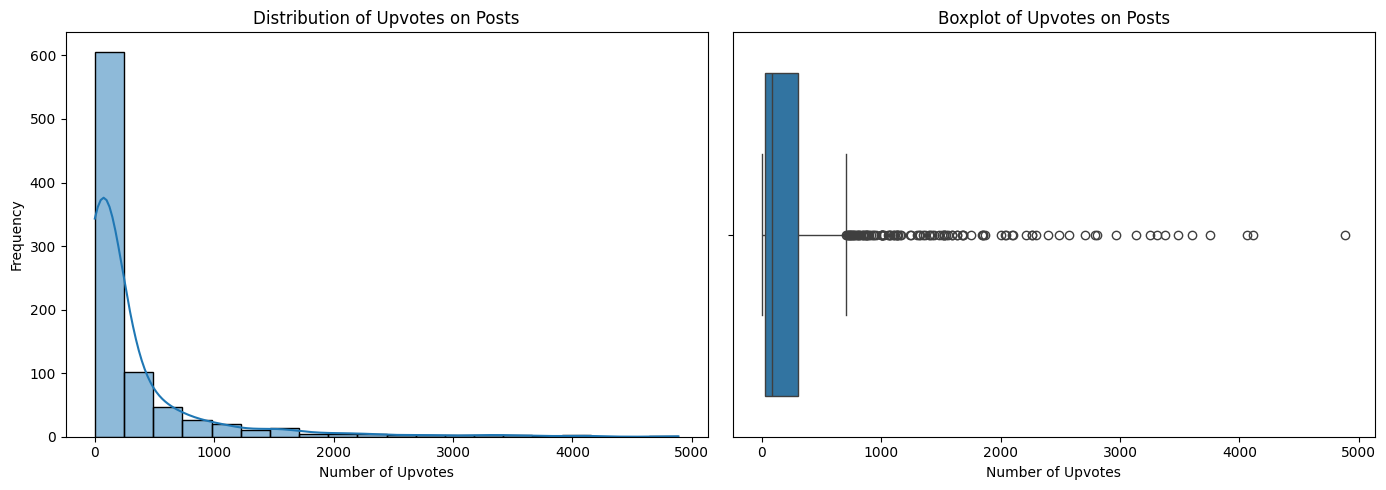

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution plot on the left
sns.histplot(df["Upvotes"], bins=20, kde=True, ax=axes[0])
axes[0].set_xlabel("Number of Upvotes")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution of Upvotes on Posts")

# Boxplot on the right
sns.boxplot(x=df["Upvotes"], ax=axes[1])
axes[1].set_xlabel("Number of Upvotes")
axes[1].set_title("Boxplot of Upvotes on Posts")

plt.tight_layout()
plt.show()


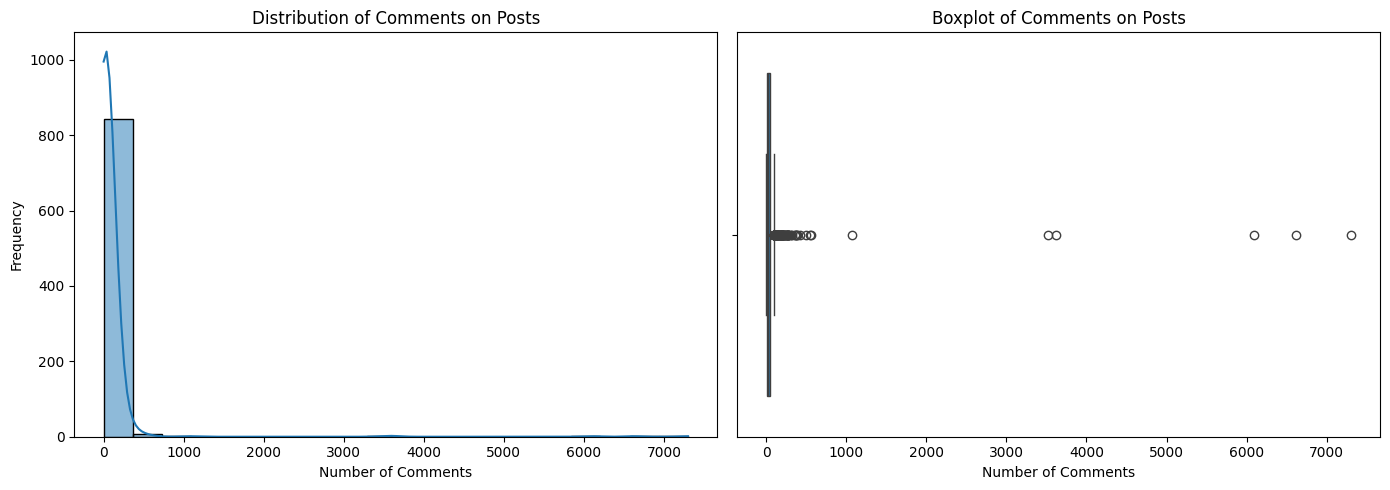

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution plot on the left
sns.histplot(df["Comments"], bins=20, kde=True, ax=axes[0])
axes[0].set_xlabel("Number of Comments")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution of Comments on Posts")

# Boxplot on the right
sns.boxplot(x=df["Comments"], ax=axes[1])
axes[1].set_xlabel("Number of Comments")
axes[1].set_title("Boxplot of Comments on Posts")

plt.tight_layout()
plt.show()


#### What's the distribution of those posts with low interaction?

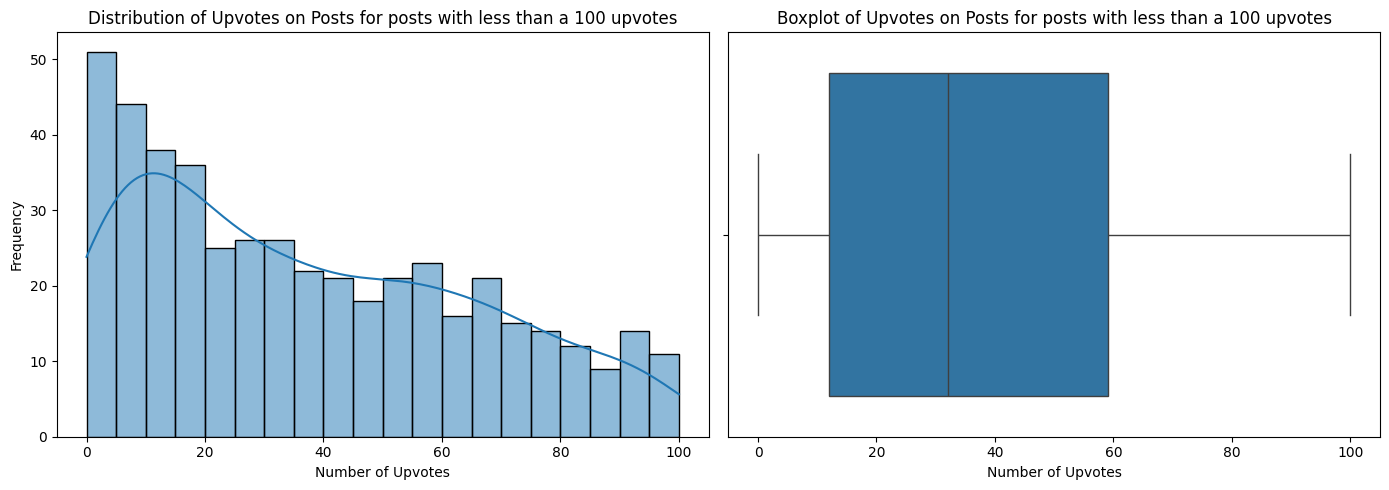

In [18]:
df_low_upvotes = df[df['Upvotes']<= 100]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution plot on the left
sns.histplot(df_low_upvotes["Upvotes"], bins=20, kde=True, ax=axes[0])
axes[0].set_xlabel("Number of Upvotes")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution of Upvotes on Posts for posts with less than a 100 upvotes")

# Boxplot on the right
sns.boxplot(x=df_low_upvotes["Upvotes"], ax=axes[1])
axes[1].set_xlabel("Number of Upvotes")
axes[1].set_title("Boxplot of Upvotes on Posts for posts with less than a 100 upvotes")

plt.tight_layout()
plt.show()


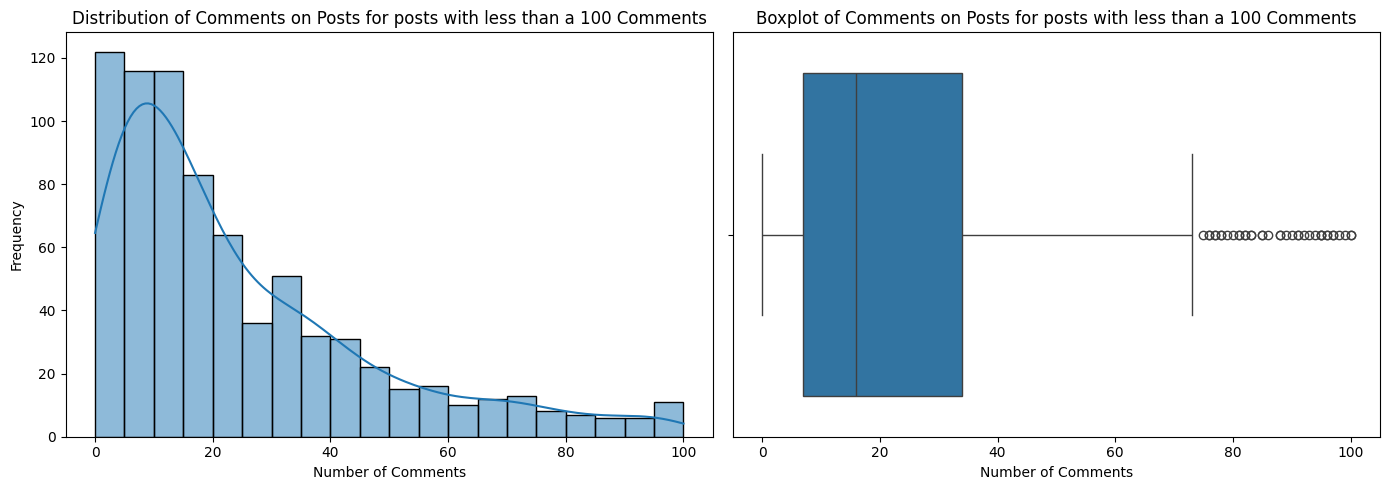

In [19]:
df_low_comments = df[df['Comments']<= 100]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution plot on the left
sns.histplot(df_low_comments["Comments"], bins=20, kde=True, ax=axes[0])
axes[0].set_xlabel("Number of Comments")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution of Comments on Posts for posts with less than a 100 Comments")

# Boxplot on the right
sns.boxplot(x=df_low_comments["Comments"], ax=axes[1])
axes[1].set_xlabel("Number of Comments")
axes[1].set_title("Boxplot of Comments on Posts for posts with less than a 100 Comments")

plt.tight_layout()
plt.show()

In [20]:
df.describe(include='all')

,Title,Upvotes,Comments,Post Date,Author,Subreddit,Self-text,Flair,Total Awards,NSFW,Stickied,Post URL,luka_in_title,lebron_in_title,lebron_or_luka
count,857,857.00000,857.000000,857,857,857,857,331,857.0,857,857,857,857,857,857
unique,848,NaN,NaN,857,490,1,385,24,NaN,1,2,856,2,2,4
top,Daily Lakers Discussion Thread,NaN,NaN,2025-04-04 17:37:38,denobino,lakers,,Team Discussion,NaN,False,False,https://streamable.com/wzqdtb,False,False,neither
freq,8,NaN,NaN,1,28,857,466,42,NaN,857,855,2,594,644,480
mean,NaN,312.61727,72.794632,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,587.51345,433.933239,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,0.00000,0.000000,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,29.00000,8.000000,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,84.00000,19.000000,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,299.00000,43.000000,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


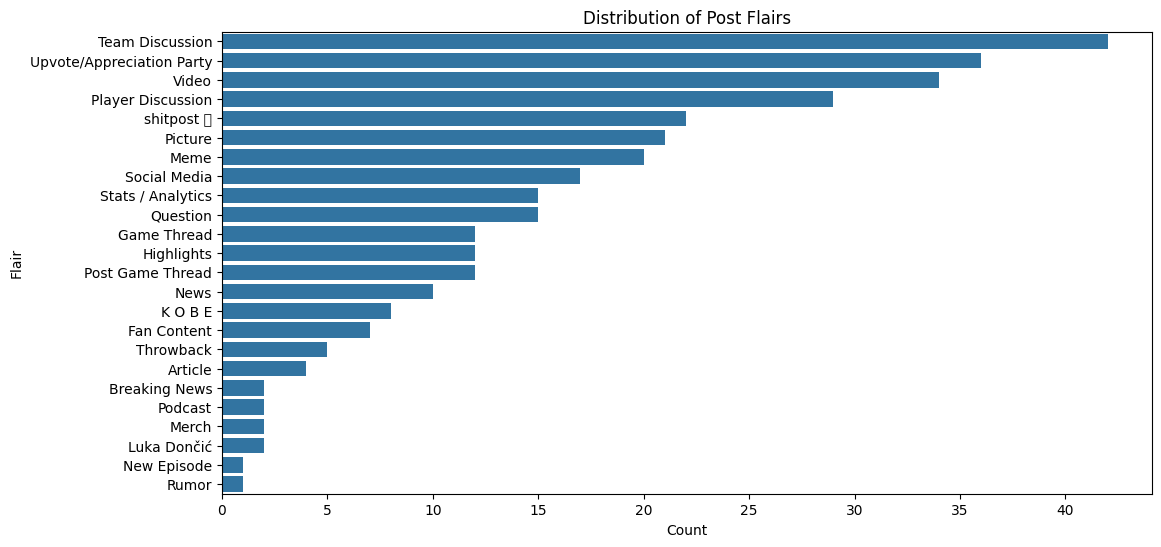

In [21]:
# Flair Distribution
if df["Flair"].nunique() > 1:
    plt.figure(figsize=(12, 6))
    sns.countplot(y=df["Flair"], order=df["Flair"].value_counts().index)
    plt.xlabel("Count")
    plt.ylabel("Flair")
    plt.title("Distribution of Post Flairs")
    plt.show()

In [22]:
df['Flair'].value_counts()

Flair
Team Discussion              42
Upvote/Appreciation Party    36
Video                        34
Player Discussion            29
shitpost 💩                   22
Picture                      21
Meme                         20
Social Media                 17
Stats / Analytics            15
Question                     15
Game Thread                  12
Highlights                   12
Post Game Thread             12
News                         10
K O B E                       8
Fan Content                   7
Throwback                     5
Article                       4
Breaking News                 2
Podcast                       2
Merch                         2
Luka Dončić                   2
New Episode                   1
Rumor                         1
Name: count, dtype: int64

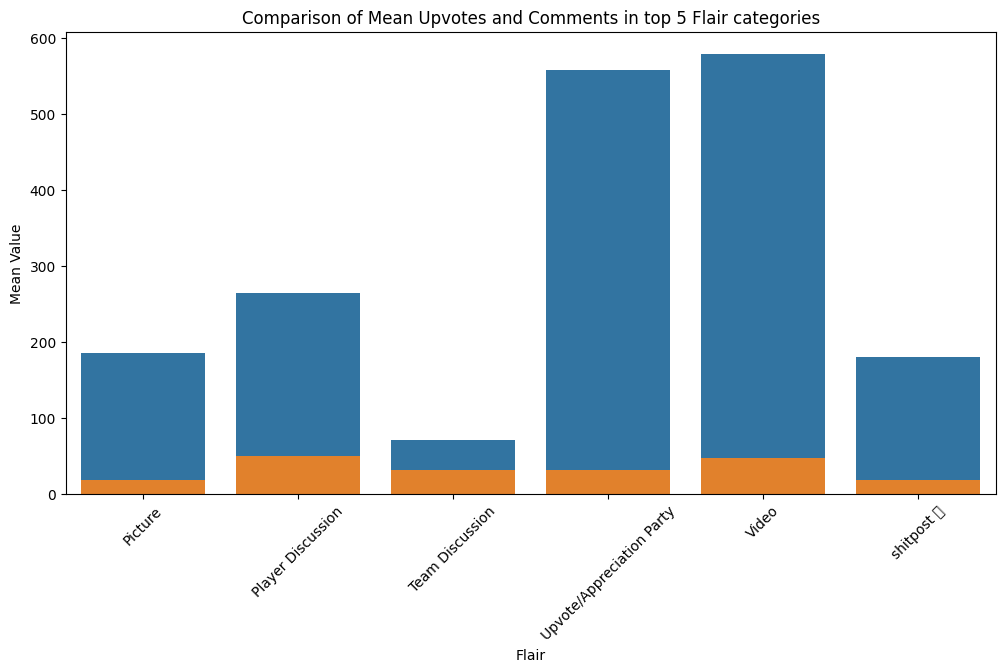

In [23]:
flair_counts = df['Flair'].value_counts() # Count how many times each Flair appears
relevant_flairs = flair_counts[flair_counts > 20].index # Keep only the top categories
df_filtered = df[df['Flair'].isin(relevant_flairs)] # Filter the DataFrame
grouped_df = df_filtered.groupby(['Flair']).agg({'Upvotes': 'mean', 'Comments': 'mean'}).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=grouped_df, x='Flair', y='Upvotes')
sns.barplot(data=grouped_df, x='Flair', y='Comments')
plt.xticks(rotation=45)
plt.xlabel("Flair")
plt.ylabel("Mean Value")
plt.title("Comparison of Mean Upvotes and Comments in top 5 Flair categories")
plt.show()



## Text preprocessing

In [24]:
import re
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

# Download necessary NLTK resources
nltk.download("vader_lexicon")
nltk.download("stopwords")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sdesc\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sdesc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
# Function for text preprocessing
def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()  # Convert to lowercase
        text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
        # text = re.sub(r"\d+", "", text)  # Remove numbers
        tokens = text.split()  # Tokenization
        stop_words = set(stopwords.words("english"))
        tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
        return " ".join(tokens)
    return ""

# Apply preprocessing
df["cleaned_title"] = df["Title"].apply(preprocess_text)

In [26]:
df[['Title','Upvotes','Comments','cleaned_title']].nlargest(10, "Comments") # Check the differences between title and cleaned

,Title,Upvotes,Comments,cleaned_title
493,Game Thread: Los Angeles Lakers (48-30) at Okl...,54,7302,game thread los angeles lakers 4830 oklahoma c...
330,Game Thread: Los Angeles Lakers (48-31) at Dal...,70,6619,game thread los angeles lakers 4831 dallas mav...
663,Game Thread: Los Angeles Lakers (47-30) at Okl...,256,6090,game thread los angeles lakers 4730 oklahoma c...
814,Game Thread: New Orleans Pelicans (21-55) at L...,55,3625,game thread new orleans pelicans 2155 los ange...
102,Game Thread: Houston Rockets (52-28) at Los An...,57,3513,game thread houston rockets 5228 los angeles l...
372,BREAKING: Nuggets have fired Mike Malone,4888,1073,breaking nuggets fired mike malone
207,Post Game Thread: The Los Angeles Lakers defea...,1105,554,post game thread los angeles lakers defeat dal...
617,Post Game Thread: The Los Angeles Lakers defea...,465,546,post game thread los angeles lakers defeat okl...
375,"Just believe, lads. Believe.",4066,490,believe lads believe
736,Daily Lakers Discussion Thread,14,426,daily lakers discussion thread


# Sentiment Analysis

In [27]:
# Initialize Model for Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

def get_sentiment_scores(text):
    scores = sia.polarity_scores(text) # get sentiment scores
    return pd.Series([scores["pos"], scores["neu"], scores["neg"], scores["compound"]])

# Apply sentiment analysis and store the scores in the df
df[["Positive", "Neutral", "Negative", "Compound"]] = df["cleaned_title"].apply(get_sentiment_scores)

In [28]:
# Classify overall sentiment
def classify_sentiment(compound_score):
    if compound_score >= 0.05:
        return "Positive"
    elif compound_score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

df["Sentiment"] = df["Compound"].apply(classify_sentiment)

In [29]:
df[["cleaned_title", "Positive", "Neutral", "Negative", "Compound", "Sentiment"]].head()

,cleaned_title,Positive,Neutral,Negative,Compound,Sentiment
0,lakers ticket sales postseason,0.000,1.000,0.000,0.0000,Neutral
1,daily lakers discussion thread,0.000,1.000,0.000,0.0000,Neutral
2,lebron james austin reaves lakers team chemistry,0.000,1.000,0.000,0.0000,Neutral
3,thank coaching staff,0.556,0.444,0.000,0.3612,Positive
4,lebron james man going say something useless p...,0.380,0.528,0.092,0.8271,Positive


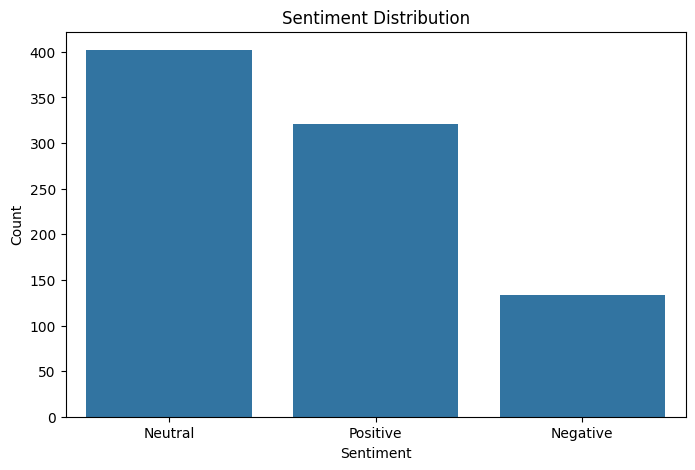

In [30]:
# Visualization: Sentiment Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x=df["Sentiment"])
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

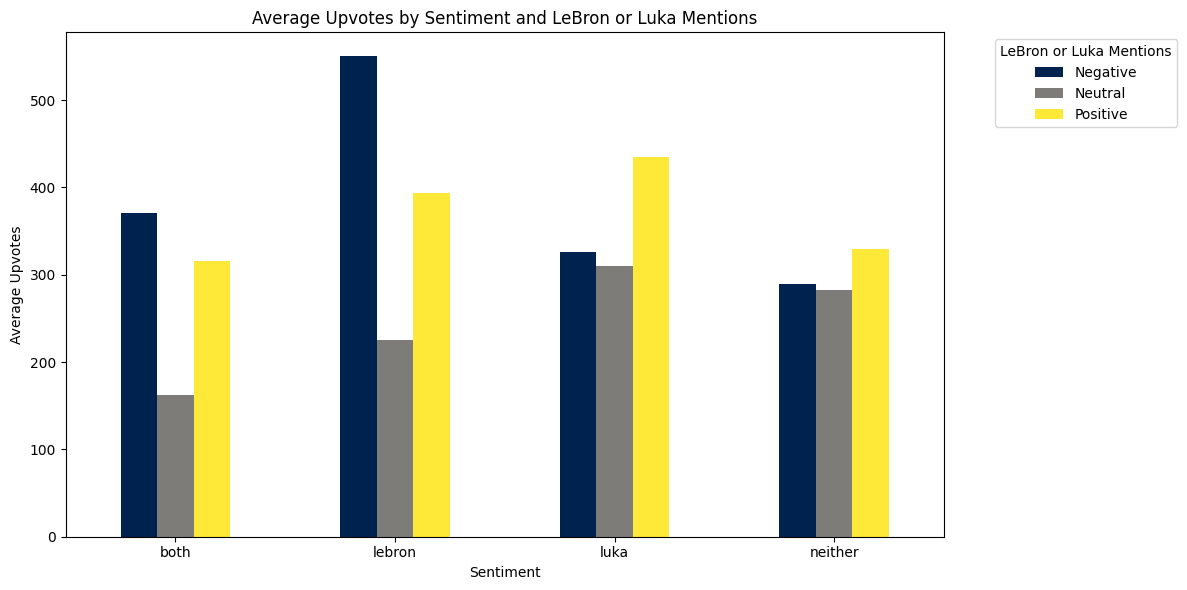

In [31]:
# Calculate the mean upvotes grouped by Sentiment and lebron_or_luka
grouped_data = df.groupby(['lebron_or_luka', 'Sentiment'])['Upvotes'].mean().unstack()

# Plot the grouped bar chart
grouped_data.plot(kind='bar', figsize=(12, 6), colormap='cividis')

plt.title('Average Upvotes by Sentiment and LeBron or Luka Mentions')
plt.xlabel('Sentiment')
plt.ylabel('Average Upvotes')
plt.xticks(rotation=0)
plt.legend(title='LeBron or Luka Mentions', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

For the **Outliers** in the Upvotes, separation of the data based on the interaction, so lower interaction posts are going to be stored in a separate df to control for the skewness in the data. We won't cap the metrics of the post so we get the effect of viral posts.

In [32]:
df_low_upvotes = df[df['Upvotes'] < 20] # Define low interaction as less than 20 upvotes in the post --> Based on the distribution of the data close to the first quartile
df_high_upvotes = df[df['Upvotes'] >= 20]

# Encoding

In [33]:
df_encoded = df_high_upvotes.copy()

# Parse date
df_encoded['Post Date'] = pd.to_datetime(df_encoded['Post Date'], errors='coerce')

# Create the dummy variable 'Weekend_Flag'
df_encoded['Weekend_Flag'] = df_encoded['Post Date'].apply(lambda x: 1 if x.weekday() >= 5 else 0)

# Encoding Flair:
# List of values to keep
retain_values = ['Team Discussion', 'Video', 'Upvote/Appreciation Party']
df['flair_fix'] = df['Flair'].apply(lambda x: x if x in retain_values else 'other') # Creating the new variable 'flair_fix'

# Drop text and URL columns not useful for modeling or repetitive
columns_to_drop = ['Title', 'Self-text', 'Post URL', 'cleaned_title', 'Post Date', 'Author', 'Flair','Positive', 'Neutral', 'Negative', 'Compound', 'lebron_or_luka']
df_encoded = df_encoded.drop(columns=columns_to_drop)

# Convert booleans to integers
bool_cols = df_encoded.select_dtypes('bool').columns
df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)

# One-hot encode relevant object columns
categorical_cols = df_encoded.select_dtypes('object').columns
df_encoded = pd.get_dummies(df_encoded, columns=categorical_cols, drop_first=True)

# Final result
print(df_encoded.shape)
df_encoded.head()

(688, 10)


,Upvotes,Comments,Total Awards,NSFW,Stickied,luka_in_title,lebron_in_title,Weekend_Flag,Sentiment_Neutral,Sentiment_Positive
2,3380,96,0,0,0,0,1,1,True,False
3,2044,52,0,0,0,0,0,1,False,True
4,1511,81,0,0,0,0,1,1,False,True
5,1444,39,0,0,0,0,0,1,False,True
6,1594,73,0,0,0,0,0,1,True,False


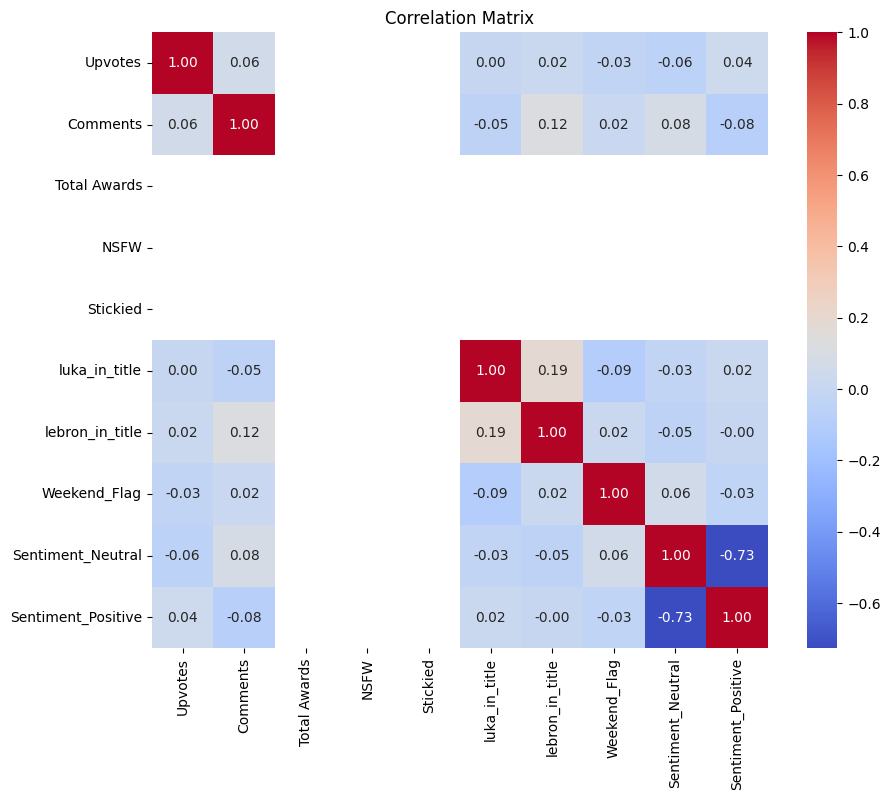

In [34]:
# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix")
plt.show()

## Feature selection

In [35]:
from sklearn.feature_selection import VarianceThreshold, SequentialFeatureSelector, RFE

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [36]:
y = df_encoded['Upvotes']
X = df_encoded.drop('Upvotes', axis=1)

In [37]:
# Low variance filter
vt = VarianceThreshold(threshold=0.01)  # Default is 0.0
X_vt = vt.fit_transform(X)
vt_features = X.columns[vt.get_support()].tolist()[:3]  # Top 3

In [38]:
# Recursive Feature Elimination (RFE)
rfe = RFE(estimator=LinearRegression(), n_features_to_select=3)
rfe.fit(X, y)
rfe_features = X.columns[rfe.support_].tolist()

In [39]:
# Sequential Feature Selector (SFS)
sfs = SequentialFeatureSelector(LinearRegression(), n_features_to_select=3, direction='forward')
sfs.fit(X, y)
sfs_features = X.columns[sfs.get_support()].tolist()

In [40]:
# Combine and compare
comparison_df = pd.DataFrame({
    'VarianceThreshold': pd.Series(vt_features),
    'RFE': pd.Series(rfe_features),
    'SequentialFeatureSelector': pd.Series(sfs_features)
})

print("Top 3 features selected by each method:")
print(comparison_df)

Top 3 features selected by each method:
  VarianceThreshold                RFE SequentialFeatureSelector
0          Comments    lebron_in_title                  Comments
1     luka_in_title       Weekend_Flag              Total Awards
2   lebron_in_title  Sentiment_Neutral         Sentiment_Neutral


In [41]:
# Implementing the variance threshold filter:
X = X[vt_features]

# Model

In [42]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Models to try:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

# Store results
results = []

# Train and evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    results.append({
        'Model': name,
        'R2 Score': r2,
        'MAE': mae,
        'RMSE': rmse
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)


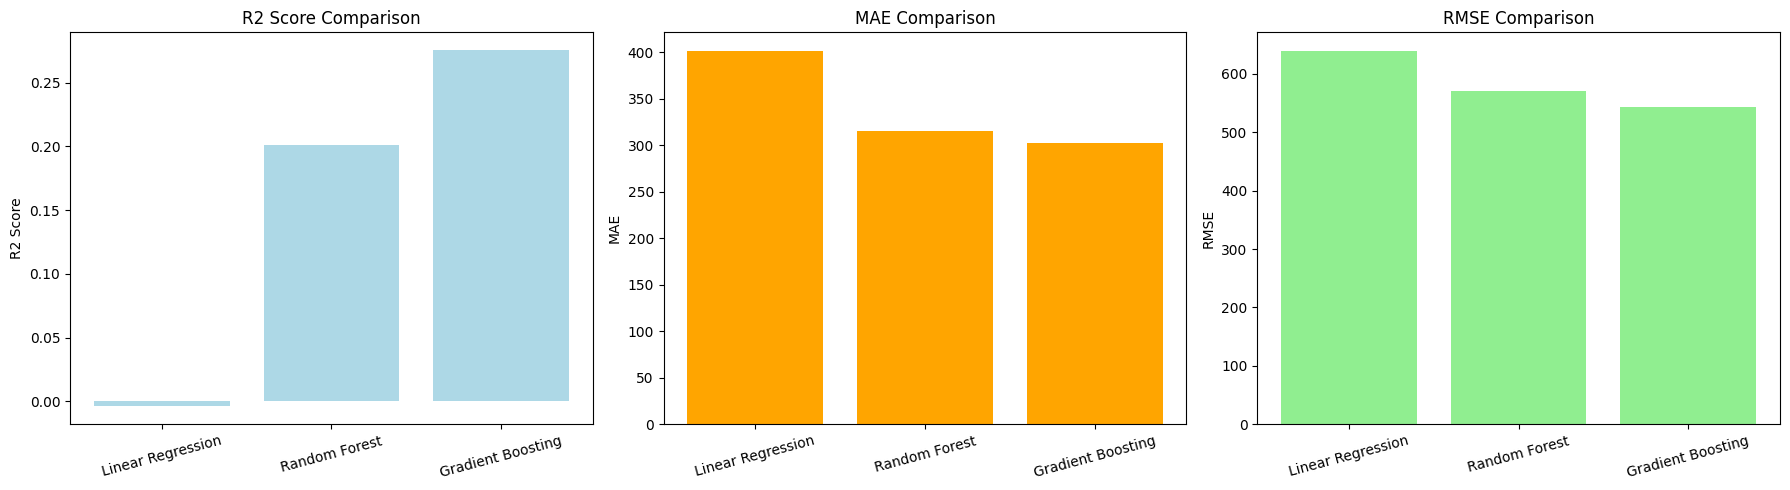

,Model,R2 Score,MAE,RMSE
0,Linear Regression,-0.003943,401.243963,639.040068
1,Random Forest,0.201335,314.889388,569.975136
2,Gradient Boosting,0.275486,301.952047,542.871644


In [43]:
# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['R2 Score', 'MAE', 'RMSE']
colors = ['lightblue', 'orange', 'lightgreen']

for i, metric in enumerate(metrics):
    axes[i].bar(results_df['Model'], results_df[metric], color=colors[i])
    axes[i].set_title(f'{metric} Comparison')
    axes[i].set_ylabel(metric)
    axes[i].set_xticklabels(results_df['Model'], rotation=15)

plt.tight_layout()
plt.show()

# Show raw scores table
results_df

None of these models is great, however, given the amount of data and the nature of the variable that we have as target, is reasonable to expect that the R2 is low because, capturing the variability in the Upvotes is inherintly very noisy and not easy to predict.
The model that is going to be used is **Random Forest** for the metrics shown.

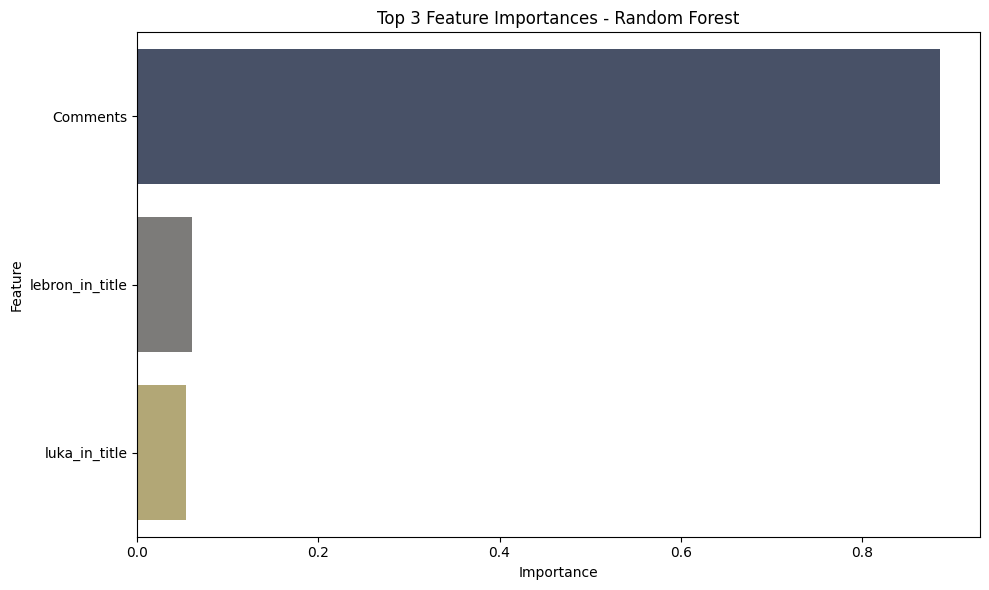

In [44]:
# Fit the selected model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importances
importances = rf_model.feature_importances_
features = X.columns
feat_imp_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Sort by importance
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='cividis')
plt.title('Top 3 Feature Importances - Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

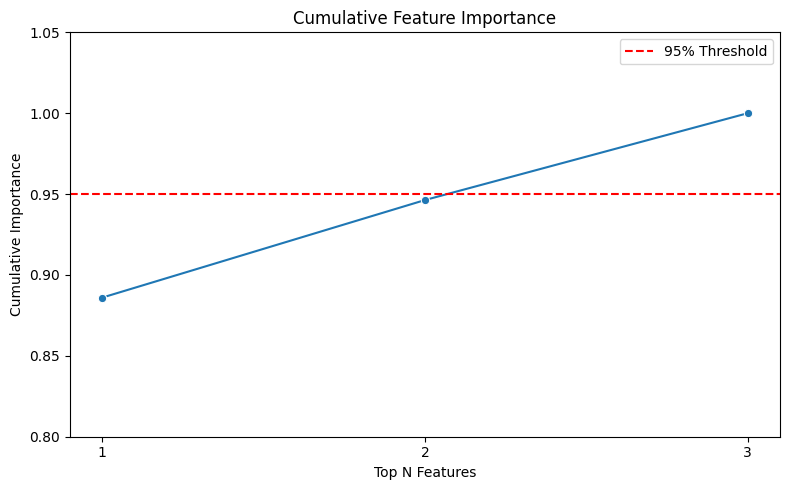

In [46]:
sorted_importances = feat_imp_df.sort_values(by='Importance', ascending=False)
sorted_importances['Cumulative Importance'] = sorted_importances['Importance'].cumsum()

plt.figure(figsize=(8, 5))
sns.lineplot(x=range(1, len(sorted_importances)+1), y=sorted_importances['Cumulative Importance'], marker='o')
plt.axhline(0.95, color='r', linestyle='--', label='95% Threshold')
plt.ylim(0.8,1.05)
plt.title("Cumulative Feature Importance")
plt.xlabel("Top N Features")
plt.xticks([1, 2, 3])
plt.ylabel("Cumulative Importance")
plt.legend()
plt.tight_layout()
plt.show()

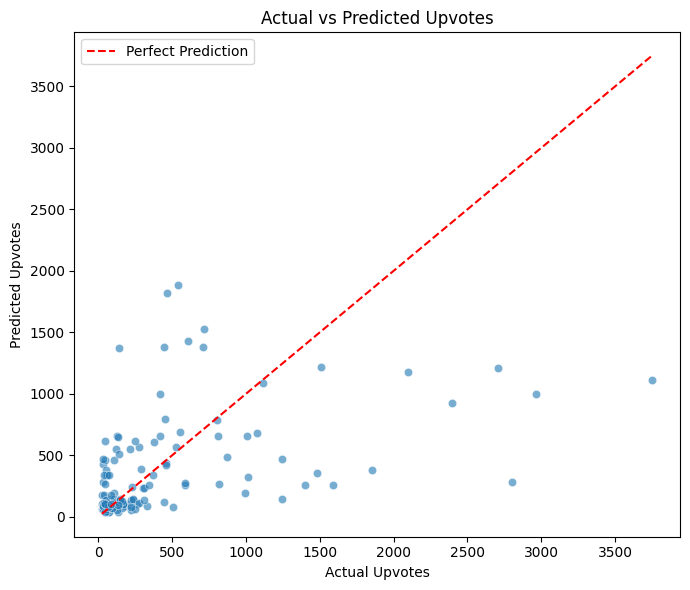

In [47]:
y_pred = rf_model.predict(X_test)

plt.figure(figsize=(7, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', label='Perfect Prediction')
plt.xlabel("Actual Upvotes")
plt.ylabel("Predicted Upvotes")
plt.title("Actual vs Predicted Upvotes")
plt.legend()
plt.tight_layout()
plt.show()

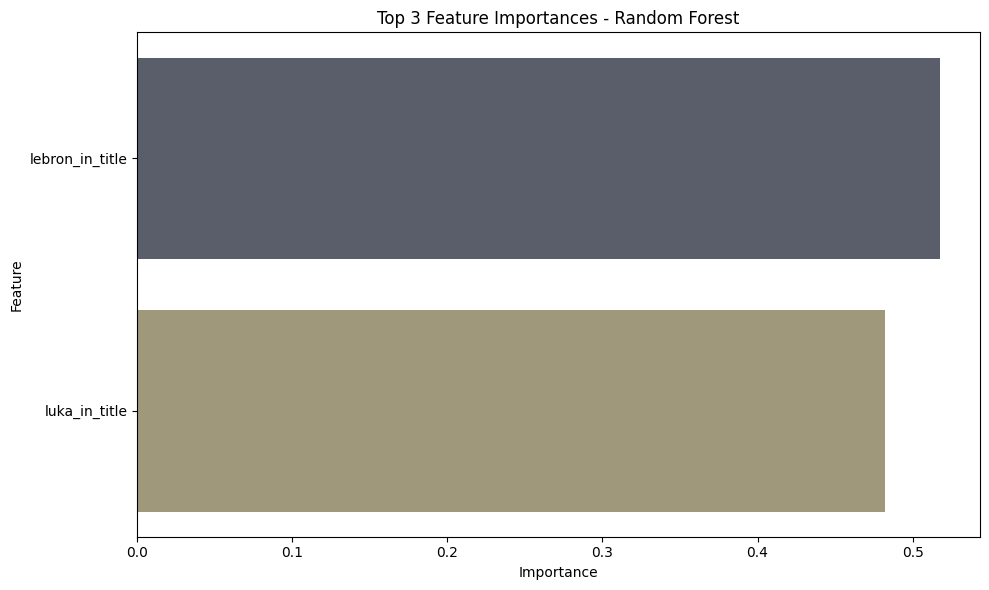

In [45]:
X_new = X[['lebron_in_title','luka_in_title']] # Compare only the two players
# Train/test split
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y, test_size=0.2, random_state=42)

# Fit the selected model
rf_model_new = RandomForestRegressor(random_state=42)
rf_model_new.fit(X_train_new, y_train)

# Get feature importances
importances_new = rf_model_new.feature_importances_
features_new = X_new.columns
feat_imp_df_new = pd.DataFrame({
    'Feature': features_new,
    'Importance': importances_new
})

# Sort by importance
feat_imp_df_new = feat_imp_df_new.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df_new, palette='cividis')
plt.title('Top 3 Feature Importances - Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# To PowerBI

In [49]:
df.to_csv("Data/PrimaryDataset-Reddit.csv", index=False)
df_encoded.to_csv("Data/df_clean_encoded.csv", index=False)
feat_imp_df.to_csv("Data/df_model_results.csv", index=False)
feat_imp_df_new.to_csv("Data/df_model_results_new.csv", index=False)